# Presentation du projet

## TODO ⌚

# Import de bibliothèques 📚

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

import os
import re
import time

from math import log2, sqrt
import numpy as np
import scipy.stats as stats
from scipy.stats import gaussian_kde, t, ttest_1samp, ttest_ind
from statsmodels.stats.proportion import proportion_confint

from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import mlflow

import matplotlib.pyplot as plt
import seaborn

# Fonctions ⚙️

In [2]:
def plot_histo(data, title=None, xlabel=None, drop_outliers=False, bins='sturges', plot_density=True):
    if drop_outliers:
        data = data[data.between(data.quantile(drop_outliers), data.quantile(1 - drop_outliers))]
    if bins == 'sturges':
        bins = int(1+log2(len(data)))
#     mu = data.mean()
#     sigma = data.std()
#     x_norm = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#     plt.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), label="Gaussienne de l'échantillon")
    plt.style.use("seaborn")
    if plot_density:
        density = gaussian_kde(data)
        xs = np.linspace(data.min(),data.max(),200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs), label="Courbe de densité")
    plt.ylabel("frequency")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.hist(data, bins=bins, density=True)
    plt.legend()
    plt.show()

In [3]:
def split_custom(label_string, delimiter=','):
    """Cette fonction prend en argument une chaine de caractères et retourne une liste"""
    return label_string.split(delimiter)

In [4]:
def get_unique_elements(panda_serie):
    """This functions returns the list of unique elements 
    out of a panda serie of strings with comma separated elements"""
    all_labels = set()
    for labels in panda_serie.map(split_custom):
        for label in labels:
            all_labels.add(label)
    return list(all_labels)

<a id='fonctionbio'></a>

In [5]:
def test_bio(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'organic' in label or 'bio' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backbio)

<a id='fonctionvege'></a>

In [6]:
def test_vege(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'vegetarian' in label or 'vegan' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backvege)

<a id='fonctionnegation'></a>

In [7]:
# # This function works but would be more efficient if it would detect the language. We'll save that for later
def test_no_something(labels, dict_something):
    """From a list of labels this function returns a booleean if 'preserative' and a negation is in one of the labels"""
    for word, negations in dict_something.items():
        for label in labels:
            label = label.lower()
            label = label.replace('-', ' ')
            bool_list = []
            #looking for word preservative
            preservative_in_label = bool(re.match(r'.*\b{}.*\b'.format(word), label))
            if preservative_in_label:
                #looking for negation
                for negation in negations:
                    if bool(re.match(r'.*\b{}\b'.format(negation), label)):
                        return True

    return False

- Retour au [script](#backconserv) Conservateurs
- Retour au [script](#backcolor) Colorants
- Retour au [script](#backGMO) OGMs

<a id='plot_bar'></a>

In [8]:
def plot_bar(data, labels, color='purple', label=None, rotation=False):
    plt.figure(figsize=(8,8))
    plt.style.use('seaborn')
    plt.bar(list(range(1, len(data)+1)), data, color=color, label=label)
    if rotation:
        angle=90
    else:
        angle=0
    plt.xticks(list(range(1, len(data)+1)), labels, rotation=angle, fontsize=12)
    plt.ylabel('Proportion par rapport au nombre de poduits du dataset (%)')
    plt.legend()
    plt.show()

- Retour au [script](#univ_1_plot_1) Labels
- Retour au [script](#univ_1_plot_2) Categories

<a id='launch_kmeans_mlflow'></a>

In [9]:
def launch_kmeans_mlflow(data_kmeans, n_clusters, comment, col_target, max_iter=300, n_init=10, init='k-means++', random_state=41):
    
    with mlflow.start_run(run_name=comment):
        
        #Train
        start = time.time()
        kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=n_init, init=init, random_state=random_state).fit(data_kmeans.drop(columns=[col_target]))
        elapsed = time.time() - start
        
        #Predict
        data_kmeans['predicted_group'] = kmeans.predict(data_kmeans.drop(columns=[col_target]))
        
        #Undestang predictions
        categs_group_number = {}
        for i in range(n_clusters):
            categs_group_number[i] = data_kmeans[data_kmeans['predicted_group'] == i][col_target].value_counts().index[0]
        
        data_kmeans = data_kmeans.merge(pd.Series(categs_group_number, name='predicted_group_label'), left_on='predicted_group', right_index=True)
        
        #Test
        data_kmeans['model_is_right'] = data_kmeans[col_target] == data_kmeans['predicted_group_label']
        
        perf = data_kmeans.model_is_right.value_counts(normalize=True).loc[True]
        
        mlflow.log_param("n_clusters", n_clusters)
        mlflow.log_param("max_iter", max_iter)
        mlflow.log_param("n_init", n_init)
        mlflow.log_param("init", init)
        mlflow.log_param("random_state", random_state)
        
        mlflow.log_metric("accuracy", perf)
        mlflow.log_metric("distinct_categs_predicted", len(data_kmeans.predicted_group_label.unique()))
        mlflow.log_metric("trainig_time", elapsed)
        mlflow.log_metric("inertie", kmeans.inertia_)
        mlflow.log_metric("nb_iter", kmeans.n_iter_)

        
        mlflow.set_tag("columns_passed", str(data_kmeans.drop(columns=[col_target, 'predicted_group', 
                                                                      'predicted_group_label']).columns.values))
        mlflow.end_run()
    return perf

- Retour au [script](#categ_kmeans) K-means

<a id='launch_gb_mlflow'></a>

In [55]:
def launch_gb_mlflow(data, comment, col_target, n_estimators=50, learning_rate=0.2,  max_depth=5, random_state=41):
    
    data_train, data_test = train_test_split(data, train_size=0.7, random_state=random_state)
    with mlflow.start_run(run_name=comment):
        start_time = time.time()
        gb_cl = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,  max_depth=max_depth, random_state=random_state).fit(data_train.drop(columns=[col_target]), data_train[col_target])
        elapsed = time.time() - start_time
        
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("random_state", random_state)
        
        mlflow.log_metric("score sur train", gb_cl.score(data_train.drop(columns=[col_target]), data_train[col_target]))
        mlflow.log_metric("score sur test", gb_cl.score(data_test.drop(columns=[col_target]), data_test[col_target]))
        mlflow.log_metric("time_train", elapsed)
        
        mlflow.end_run()

- Retour au [script](#categ_gb) Gradient boosting

# Données 🎁

In [10]:
data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t')

C:\Users\S053567\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,12,26,27,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
data.shape

(1524579, 183)

In [12]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

# Profiling 🔍

Etant données les dimensions de ce dataset, je vais réaliser l'analyse préliminaire avec Pandas Profiling. L'analyse est exportée en HTML pour une meilleure lisibilité du NB

In [13]:
# profile = ProfileReport(data, title="Report on OpenFoodFacts", minimal=True)

In [14]:
# profile.to_file('profile_report.html')

Voir le report : [cliquer ici](profile_report.html)

# Idee : 💡
### A partir d'un produit, proposer des produits similaires ayant un emballage meilleur. Appuyer l'analyse par des etudes sur le lien entre l'emballage plastique et les mauvaises caractéristiques nutritionnelles.
## Mieux manger serait-il lié à l'emballage?

Afin de vérifier la faisibilité de cette étude, nous allons déterminer les features necessaires, filtrer les NAN et regarder la taille du dataset filtré

In [15]:
col_necessaires = ['labels_en', 'saturated-fat_100g', 'categories_en', 
                   'packaging_tags', 'additives_n', 'ingredients_from_palm_oil_n', 
                   'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
# TODO : REMPLACER CATEGORIES PAR pnns-goups

In [16]:
data_filtre = data.dropna(subset=col_necessaires)

In [17]:
data_filtre.shape

(92135, 183)

Cette quantité a l'air suffisante à première vue

# Nettoyage 🧼

Les colonnes suivantes necessitent une attention particulière du fait de leur forte cardinalité:
- [Labels](#nett_1)
- [Categories](#nett_2)
- [Packaging](#nett_3)

<a id='nett_1'></a>
## Labels 🏷️

In [18]:
data_filtre.labels_en.describe()

count         92135
unique        31672
top       Green Dot
freq           5134
Name: labels_en, dtype: object

Cette variable a une forte cardinalité et est qualitative. Regardons les instances les plus fréquentes

In [19]:
data_filtre.labels_en.value_counts().head(10)

Green Dot                                       5134
Made in France                                  2206
Gluten-free                                     1605
Vegetarian,Vegan                                1512
Organic,EU Organic,AB Agriculture Biologique    1275
Organic                                         1189
No preservatives                                1170
Green Dot,Made in France                         780
Made in Germany                                  700
Vegetarian                                       696
Name: labels_en, dtype: int64

On voit que les données sont souvent séparées par des virgules et que beaucoup de labels se répétent

In [20]:
labels_unique = get_unique_elements(data_filtre.labels_en)
len(labels_unique)

9600

Grâce à ce traitement, on obtient la cardinalité réelle mais c'est toujours trop

Dans l'idéal, pour cette étude, j'aimerais pouvoir séparer les labels avec ces grandes catégories suivantes:

In [21]:
labels_simple = ['organic', 'vegetarian_or_vegan', 'no_preservatives', 'no_colorings', 'sustainable', 'no_gmos', 'no_artificial_flavors']

Je vais partir sur une approche "Dummy" pour faciliter les filtrages. En effet je ne peux résumer un produit à un seul label.

<a id='backbio'></a>

### Gestion du Bio 🌿 (accès à la fonction [ici](#fonctionbio))

In [22]:
data_filtre.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

In [23]:
data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)

<ipython-input-23-1c4cc4edf2d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)


<a id='backvege'></a>

### Gestion du Végétarien ❤️🐖 (accès à la fonction [ici](#fonctionvege))

In [24]:
data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)

<ipython-input-24-1be3452212da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)


<a id='backconserv'></a>

### Gestion des conservateurs 🧂(accès à la fonction [ici](#fonctionnegation))

In [25]:
preserv = []
for label in labels_unique:
    label = label.lower()
    if 'konser' in label:
        preserv.append(label)

In [26]:
# preserv

In [27]:
negations_english = ["no", "free", "without", '0', 'non']
negations_french = ["pas", "sans", "0", "aucun"]
negations_spanish= ['no', 'sin', 'zero', '0', 'libre', 'cero']
negations_portuguese = ['sem', 'nao']
negations_germanique = ['nie', 'bez', 'ohne', 'frei', 'utan', 'brez', 'keine']
dict_conservateur = {"conservateur": negations_french, "preservative": negations_english, 
                     'conservante':negations_spanish + negations_portuguese, 'konser': negations_germanique}

In [28]:
data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)

<ipython-input-28-7ecc0dafc191>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)


In [29]:
data_filtre['is_labeled_preserv_free'].value_counts()

False    82654
True      9481
Name: is_labeled_preserv_free, dtype: int64

<a id='backcolor'></a>

### Gestion des Colorants 🌈 (accès à la fonction [ici](#fonctionnegation))

In [30]:
color = []
for label in labels_unique:
    label = label.lower()
    if 'color' in label:
        color.append(label)

In [31]:
# color

In [32]:
dict_colorant = {"color": negations_french + negations_english + negations_spanish, "corante":negations_portuguese, 'farb': negations_germanique}

In [33]:
data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)

<ipython-input-33-e97131e051d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)


In [34]:
data_filtre['is_labeled_colorings_free'].value_counts()

False    84832
True      7303
Name: is_labeled_colorings_free, dtype: int64

<a id='backGMO'></a>

### Gestion des OGMs 🧬 (accès à la fonction [ici](#fonctionnegation))

In [35]:
ogm = []
for label in labels_unique:
    label = label.lower()
    if 'gmo' in label:
        ogm.append(label)

In [36]:
# ogm

In [37]:
dict_ogm = {"ogm": negations_french + negations_portuguese, 'gmo': negations_english + negations_portuguese, 'gvo': negations_germanique}

In [38]:
data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)
# data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(lambda x : test_no_something(x, dict_ogm), axis=1) #essayer 

<ipython-input-38-af83a8e75941>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)


In [39]:
data_filtre['is_labeled_gmos_free'].value_counts()

False    89979
True      2156
Name: is_labeled_gmos_free, dtype: int64

<a id='nett_2'></a>
## Categories 🗂️

Je pensais d'abord utiliser les données categories_n. mais la données pnns_groups_2/pnns_groups_1 est déjà travaillée et est renseignée à presque 100%

### Groups 2 (39 classes)

In [40]:
data_filtre['pnns_groups_2'].value_counts(normalize=True).head(8)

Biscuits and cakes    0.089195
One-dish meals        0.085744
unknown               0.082271
Sweets                0.056330
Processed meat        0.055278
Cereals               0.054822
Milk and yogurt       0.052445
Cheese                0.050806
Name: pnns_groups_2, dtype: float64

In [41]:
data_filtre.loc[:,'pnns_groups_2'] = data_filtre.loc[:,'pnns_groups_2'].map(lambda x:x.lower()) #Inplace = true

C:\Users\S053567\Anaconda3\envs\env_OC_P03\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [42]:
data_filtre = data_filtre.replace('pizza pies and quiche', 'pizza pies and quiches')

### Groups 1 (9 classes)

In [150]:
data_filtre['pnns_groups_1'].value_counts(normalize=True)

Sugary snacks              0.178088
Milk and dairy products    0.135379
Cereals and potatoes       0.123635
Fish Meat Eggs             0.115148
Composite foods            0.101830
unknown                    0.082271
Beverages                  0.072373
Fruits and vegetables      0.061942
Fat and sauces             0.056081
Salty snacks               0.054801
fruits-and-vegetables      0.010040
sugary-snacks              0.008249
cereals-and-potatoes       0.000152
salty-snacks               0.000011
Name: pnns_groups_1, dtype: float64

In [151]:
data_filtre = data_filtre.replace('fruits-and-vegetables', 'Fruits and vegetables')
data_filtre = data_filtre.replace('sugary-snacks', 'Sugary snacks')
data_filtre = data_filtre.replace('cereals-and-potatoes', 'Cereals and potatoes')
data_filtre = data_filtre.replace('salty-snacks', 'Salty snacks')

In [152]:
data_filtre['pnns_groups_1'].value_counts(normalize=True)

Sugary snacks              0.186337
Milk and dairy products    0.135379
Cereals and potatoes       0.123787
Fish Meat Eggs             0.115148
Composite foods            0.101830
unknown                    0.082271
Beverages                  0.072373
Fruits and vegetables      0.071982
Fat and sauces             0.056081
Salty snacks               0.054811
Name: pnns_groups_1, dtype: float64

<a id='categ_kmeans'></a>

### Algorithme K-Means pour compléter les données  🧮 

L'idée est d'entrainer à partir de données numériques nutritionnelles un modèle pouvant prédire la catégorie a laquelle appartient un produit n'ayant pas de category tag

In [43]:
len(data_filtre['pnns_groups_1'].unique())

14

In [44]:
data_filtre['pnns_groups_2'].value_counts().head(5)

biscuits and cakes    8218
one-dish meals        7900
unknown               7580
sweets                5190
processed meat        5093
Name: pnns_groups_2, dtype: int64

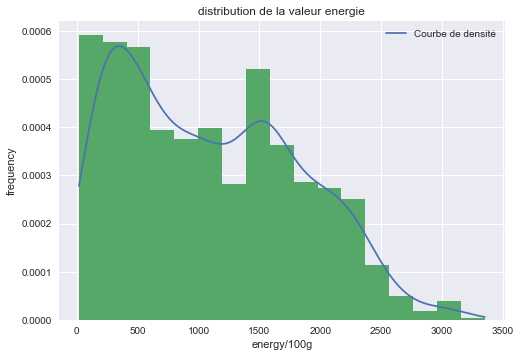

In [176]:
plot_histo(data_filtre['energy_100g'], title="distribution de la valeur energie", drop_outliers=0.01, xlabel="energy/100g")

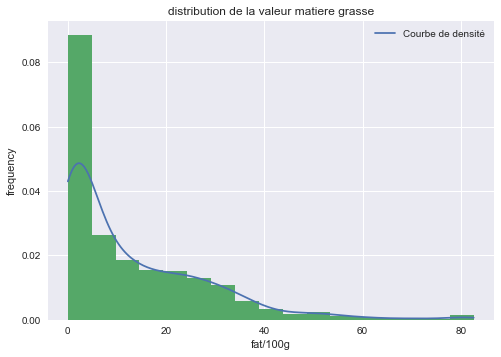

In [46]:
plot_histo(data_filtre['fat_100g'], title="distribution de la valeur matiere grasse", drop_outliers=0.01, xlabel="fat/100g")

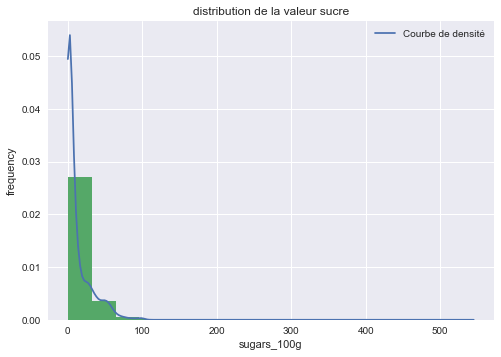

In [47]:
plot_histo(data_filtre['sugars_100g'], title="distribution de la valeur sucre", drop_outliers=0, xlabel="sugars_100g")

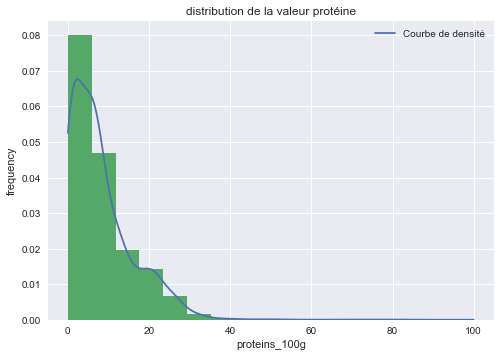

In [48]:
plot_histo(data_filtre['proteins_100g'], title="distribution de la valeur protéine", drop_outliers=0, xlabel="proteins_100g")

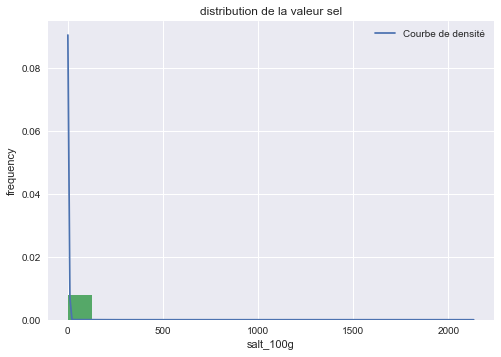

In [49]:
plot_histo(data_filtre['salt_100g'], title="distribution de la valeur sel", drop_outliers=0, xlabel="salt_100g")

Tentons de completer les données classées en unknown

In [185]:
data_kmeans = data_filtre[['energy_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'proteins_100g', 'salt_100g', 'pnns_groups_1']]
data_kmeans = data_kmeans[data_kmeans['pnns_groups_1'] != 'unknown']
data_kmeans = data_kmeans[data_kmeans['fat_100g'] <= 100]
data_kmeans = data_kmeans[data_kmeans['sugars_100g'] <= 100]
data_kmeans = data_kmeans[data_kmeans['proteins_100g'] <= 100]
data_kmeans = data_kmeans[data_kmeans['salt_100g'] <= 100]
data_kmeans = data_kmeans[data_kmeans['saturated-fat_100g'] <= 100]
data_kmeans = data_kmeans[data_kmeans['energy_100g'] <= data_kmeans['energy_100g'].quantile(0.99)]

In [180]:
col_target = "pnns_groups_1"
#Train
start = time.time()
kmeans = KMeans(n_clusters=9, max_iter=300, n_init=10, init='random', random_state=41).fit(data_kmeans.drop(columns=[col_target]))
elapsed = time.time() - start

#Predict
data_kmeans['predicted_group'] = kmeans.predict(data_kmeans.drop(columns=[col_target]))

#Undestang predictions
categs_group_number = {}
for i in range(9):
    categs_group_number[i] = data_kmeans[data_kmeans['predicted_group'] == i][col_target].value_counts().index[0]

data_kmeans = data_kmeans.merge(pd.Series(categs_group_number, name='predicted_group_label'), left_on='predicted_group', right_index=True)

#Test
data_kmeans['model_is_right'] = data_kmeans[col_target] == data_kmeans['predicted_group_label']

perf = data_kmeans.model_is_right.value_counts(normalize=True).loc[True]

In [181]:
data_kmeans

,energy_100g,fat_100g,sugars_100g,saturated-fat_100g,proteins_100g,salt_100g,pnns_groups_1,predicted_group,predicted_group_label,model_is_right
323,450.0,2.20,0.50,0.90,6.80,0.7000,Composite foods,3,Fish Meat Eggs,False
722,427.0,0.10,22.80,0.10,1.20,1.8000,Fat and sauces,3,Fish Meat Eggs,False
1846,573.0,6.80,1.50,3.80,5.00,1.5000,Cereals and potatoes,3,Fish Meat Eggs,False
1983,564.0,2.00,2.90,0.70,24.50,1.9750,Fish Meat Eggs,3,Fish Meat Eggs,True
2502,485.0,1.90,11.00,0.40,13.10,2.5500,Fish Meat Eggs,3,Fish Meat Eggs,True
...,...,...,...,...,...,...,...,...,...,...
1514899,2670.0,54.00,4.60,7.60,28.60,0.0254,Cereals and potatoes,0,Fat and sauces,False
1517313,2778.0,72.30,1.00,8.10,1.50,0.9525,Fat and sauces,0,Fat and sauces,True
1517505,2790.0,56.40,24.30,35.30,5.60,0.1000,Sugary snacks,0,Fat and sauces,False
1517508,2761.0,58.80,26.60,34.90,4.40,0.6000,Sugary snacks,0,Fat and sauces,False


In [182]:
from sklearn import metrics  
print(metrics.classification_report(data_kmeans[col_target],  data_kmeans['predicted_group_label'], target_names=data_kmeans[col_target].unique()))

C:\Users\S053567\Anaconda3\envs\env_OC_P03\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\S053567\Anaconda3\envs\env_OC_P03\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

        Composite foods       0.38      0.93      0.54      6667
         Fat and sauces       0.44      0.41      0.43     11388
   Cereals and potatoes       0.00      0.00      0.00      9378
         Fish Meat Eggs       0.61      0.20      0.30      4386
Milk and dairy products       0.26      0.84      0.40     10597
  Fruits and vegetables       0.00      0.00      0.00      6625
          Sugary snacks       0.00      0.00      0.00     12461
              Beverages       0.00      0.00      0.00      5042
           Salty snacks       0.59      0.73      0.65     17151

               accuracy                           0.40     83695
              macro avg       0.25      0.35      0.26     83695
           weighted avg       0.28      0.40      0.30     83695



C:\Users\S053567\Anaconda3\envs\env_OC_P03\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
metrics.confusion_matrix(data_kmeans[col_target],  data_kmeans['predicted_group_label'])

array([[ 6183,   114,     0,     3,   334,     0,     0,     0,    33],
       [  220,  4677,     0,    92,  3286,     0,     0,     0,  3113],
       [  982,   332,     0,     3,  7659,     0,     0,     0,   402],
       [  925,   216,     0,   876,  1899,     0,     0,     0,   470],
       [  290,   720,     0,    10,  8893,     0,     0,     0,   684],
       [ 4585,   345,     0,    69,  1387,     0,     0,     0,   239],
       [ 2724,  1937,     0,     0,  6863,     0,     0,     0,   937],
       [   94,   363,     0,   273,  1303,     0,     0,     0,  3009],
       [  188,  1871,     0,   103,  2409,     0,     0,     0, 12580]],
      dtype=int64)

In [51]:
# mlflow.create_experiment("k_means_opti_groups_1")

In [187]:
mlflow.set_experiment("k_means_opti_groups_1")

Voir la [fonction source](#launch_kmeans_mlflow)

In [188]:
launch_kmeans_mlflow(data_kmeans, 9, "Test bilel", 'pnns_groups_1', max_iter=300, init='random', n_init=10)

0.3967859489814206

- Voir le suivi MlFlow avec target = pnns_groups_1 : [cliquer ici](http://sbc.covea.priv:5000/#/experiments/3) (Mlflow doit être lancé)
- Voir le suivi MlFlow avec target = pnns_groups_2 : [cliquer ici](http://sbc.covea.priv:5000/#/experiments/2) (Mlflow doit être lancé)

<a id='categ_gb'></a>

### Même idée mais avec un  Gradient Boosting Classifier  🧮 

In [54]:
data_gb = data_filtre[['energy_100g', 'fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'pnns_groups_1']]
data_gb = data_gb[data_gb['pnns_groups_1'] != 'unknown']

Voir la [fonction source](#launch_gb_mlflow)

In [159]:
mlflow.create_experiment('test_gb_groups_2')

'6'

In [163]:
mlflow.set_experiment('test_gb_groups_2')

In [164]:
launch_gb_mlflow(data_kmeans, 'categories nettoyées', 'pnns_groups_2', n_estimators=100, learning_rate=0.1,  max_depth=8, random_state=41)

- Voir le suivi MlFlow avec target = pnns_groups_1: [cliquer ici](http://sbc.covea.priv:5000/#/experiments/5) (Mlflow UI doit être lancé)
- Voir le suivi MlFlow avec target = pnns_groups_2: [cliquer ici](http://sbc.covea.priv:5000/#/experiments/6) (Mlflow UI doit être lancé)

<a id='nett_3'></a>
## Packaging 📦
Cette donnée essentielle à notre étude necessite un gros travail de traitement

In [59]:
data_filtre.packaging_tags.describe()

count                92135
unique               18402
top       sachet,plastique
freq                  4877
Name: packaging_tags, dtype: object

Même configuration : forte cardinalité d'une variable qualitative

In [60]:
data_filtre.packaging_tags.value_counts().head(50)

sachet,plastique               4877
plastique                      2623
kunststoff                     2017
carton                         1958
frais,plastique                1598
barquette,plastique            1452
frais                          1450
carton,plastique               1221
plastic                        1188
sachet                         1155
bouteille,plastique            1081
glas                           1077
bocal,verre                    1024
sachet-plastique                910
conserve                        804
plastico                        630
brique,carton                   614
bouteille,verre                 596
carton,boite,plastique          558
karton                          541
sachet,plastique,surgele        523
bocal,verre,couvercle,metal     518
barquette                       488
papier                          486
conserve,metal                  481
barquette,plastique,frais       476
brique                          464
bocal,verre,metal           

Dans un premier temps je me limiterai à une analyse binaire Plastique/Pas de plastique

En regardant les produits dont le packaging tag est "sachet", je vois qu'ils sont en plastique

In [61]:
data_filtre[data_filtre['packaging_tags'] == 'sachet'][['product_name', 'url']].sample(1).iloc[0,1]

'http://world-en.openfoodfacts.org/product/3256226401443/fleurs-sans-gelatine-bon-vegetarien-u'

In [62]:
plastic_test = lambda x : bool(re.search(r'plast', x)) or bool(re.search(r'kunstoff', x)) or bool(re.search(r'sachet',x))
data_filtre["has_plastic"] = data_filtre['packaging_tags'].map(plastic_test)

Voir l'[analyse univariée du critère plastique](#univ_3)

# Analyses Univariées 📊
##### - [Labels](#univ_1)
##### - [Categories](#univ_2)
##### - [Packaging](#univ_3)
##### - [Additifs](#univ_4)
##### - [Huile de palme](#univ_5)
##### - [Graisse saturée](#univ_6)
##### - [Nutriscore numérique](#univ_7)
##### - [Nutriscore catégorique](#univ_8)

<a id='univ_1'></a>
## Labels 🏷️

Les labels nous donne des informations sur le type d'aliment et surtout sur le soin apporté par l'industriel pour le produit.
L'analyse en histogramme nous permet ici d'y voir plus clair sur la quantité de labels dans le dataset mais ne nous permet pas de réaliser de véritables analyses univariée.
Il serait interessant de mener des analyse univariées d'un autre paramètre sur un classe de labels

In [63]:
labels_to_inspect = ['is_labeled_organic',
                     'is_labeled_vege_or_vegan',
                     'is_labeled_preserv_free',
                     'is_labeled_colorings_free',
                     'is_labeled_gmos_free']

qtty_label = [data_filtre[label_to_inspect].value_counts().loc[True] for label_to_inspect in labels_to_inspect]
percent_label = np.array(qtty_label)/len(data_filtre) * 100

<a id='univ_1_plot_1'></a>

Voir fonction [ici](#plot_bar)

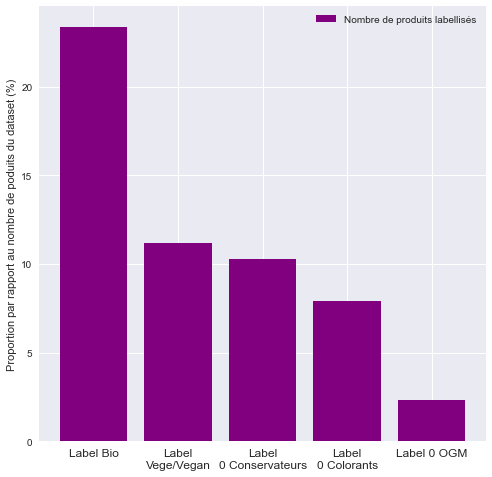

In [64]:
plot_bar(percent_label, ['Label Bio', 'Label\nVege/Vegan', 'Label\n0 Conservateurs', 'Label\n0 Colorants', 'Label 0 OGM'], label='Nombre de produits labellisés')

<a id='univ_2'></a>
## Categories 🗂️

In [65]:
data_filtre.pnns_groups_2.describe()

count                  92135
unique                    39
top       biscuits and cakes
freq                    8218
Name: pnns_groups_2, dtype: object

Les catégories de pnns_groups_2 sont bien mieux référencées que celles des categories_en

In [66]:
data_filtre.pnns_groups_2.value_counts().head(10)

biscuits and cakes      8218
one-dish meals          7900
unknown                 7580
sweets                  5190
processed meat          5093
cereals                 5062
milk and yogurt         4832
cheese                  4681
dressings and sauces    3686
vegetables              3316
Name: pnns_groups_2, dtype: int64

Voir la fonction [ici](#plot_bar)

<a id='univ_1_plot_2'></a>

In [67]:
data_bar_categ = data_filtre.pnns_groups_2.value_counts()/len(data_filtre) *100
labels = list(data_filtre.pnns_groups_2.value_counts().index)

In [68]:
len(labels)

39

No handles with labels found to put in legend.


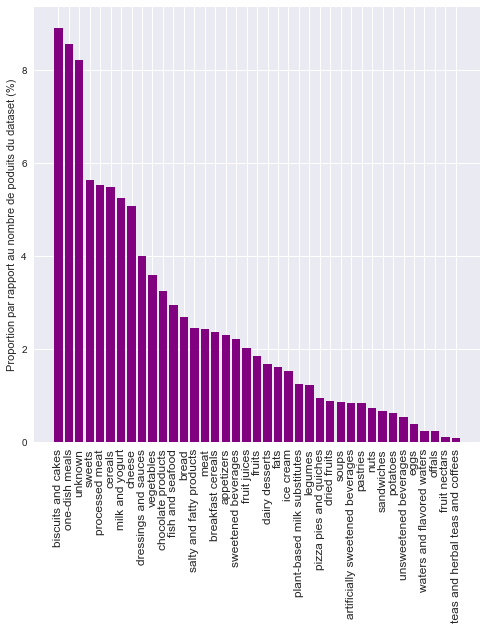

In [69]:
plot_bar(data_bar_categ, labels, rotation=True)

Dans le cadre du projet d'application, cette colonne nous servira a proposer un produit de la même catégorie. Il faudra également la rassembler en moins de cardinalités

On peut aussi se servir de cette colonne pour un analyse spécifique d'une catégorie d'aliments. par exemple pour voir si le nutriscore est meilleur sans plastique pour certaines catégories.

<a id='univ_3'></a>
## Packaging 📦

In [70]:
data_filtre.packaging_tags.describe()

count                92135
unique               18402
top       sachet,plastique
freq                  4877
Name: packaging_tags, dtype: object

In [71]:
data_filtre.packaging_tags.value_counts().head(10)

sachet,plastique       4877
plastique              2623
kunststoff             2017
carton                 1958
frais,plastique        1598
barquette,plastique    1452
frais                  1450
carton,plastique       1221
plastic                1188
sachet                 1155
Name: packaging_tags, dtype: int64

Pour l'analyse univariée nous nous contenterons pour le moment d'analyser la variable binaire "has_plastic" calculée dans la partie [nettoyage](#nett_3)

In [72]:
data_filtre['has_plastic'].value_counts()

True     49262
False    42873
Name: has_plastic, dtype: int64

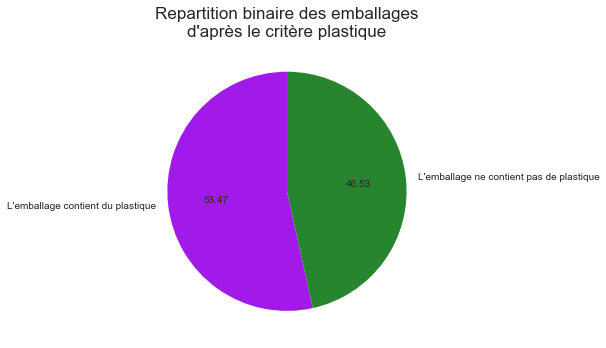

In [73]:
plt.title("Repartition binaire des emballages\nd'après le critère plastique", fontsize=17)
plt.pie(data_filtre['has_plastic'].value_counts(), labels=["L'emballage contient du plastique", "L'emballage ne contient pas de plastique"], 
        colors=['#A21AEA', '#278530'], autopct='%.2f', startangle=90)
plt.show()

Une majorité de produits sont emballés en partie ou totalement dans du plastique

#### Intervalle de confiance sur cette repartition:

In [74]:
data_filtre['has_plastic'].value_counts().loc[False]

42873

In [75]:
n_produits_total = len(data_filtre)
n_produits_sans_plastique = data_filtre['has_plastic'].value_counts().loc[False]
proportion_estim = n_produits_sans_plastique / n_produits_total

In [76]:
proportion_estim

0.4653280512291746

Niveau de confiance

In [77]:
alpha = 0.05
interv_conf_propor_pduits_sans_plastique = proportion_confint(n_produits_sans_plastique, n_produits_total, alpha=alpha, method='normal')
interv_conf_propor_pduits_sans_plastique

(0.4621072858615713, 0.4685488165967779)

<a id='univ_4'></a>
## Additifs 🧪

In [78]:
data_filtre.additives_n.describe()

count    92135.000000
mean         1.572671
std          2.238584
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         30.000000
Name: additives_n, dtype: float64

In [79]:
data_filtre.additives_n.head(5)

323    2.0
346    4.0
384    0.0
385    1.0
393    3.0
Name: additives_n, dtype: float64

Cette variable est une variable quantitative visiblement entière

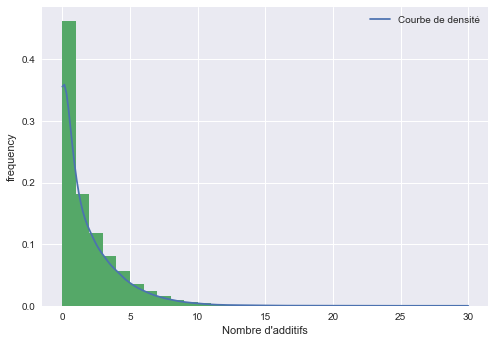

In [80]:
plot_histo(data_filtre.additives_n, bins=30, xlabel="Nombre d'additifs")

J'aimerais utiliser cette variable pour tester la correlation entre le nombre d'additifs et la présence de plastique dans l'emballage

<a id='univ_5'></a>
## Huile de palme 🌴

In [81]:
data_filtre.ingredients_from_palm_oil_n.describe()

count    92135.000000
mean         0.037738
std          0.193165
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: ingredients_from_palm_oil_n, dtype: float64

In [82]:
data_filtre.ingredients_from_palm_oil_n.value_counts()

0.0    88704
1.0     3385
2.0       46
Name: ingredients_from_palm_oil_n, dtype: int64

<a id='univ_6'></a>
## Graisse saturée 🍟

In [83]:
data_filtre['saturated-fat_100g'].describe()

count    92135.000000
mean         5.479181
std          8.364213
min          0.000000
25%          0.350000
50%          2.000000
75%          7.650000
max        140.000000
Name: saturated-fat_100g, dtype: float64

Cette variable quantitative donne le nombre de grammes de graisse saturée pour 100g de produit. Il n'est donc pas logique que certains produits aient une valeur de plus de 100.
Regardons ces valeurs

In [84]:
data_filtre[data_filtre['saturated-fat_100g'] >= 100][['product_name', 'nutriscore_grade', 'quantity', 'saturated-fat_100g', 'serving_size', 'ingredients_text']]

,product_name,nutriscore_grade,quantity,saturated-fat_100g,serving_size,ingredients_text
652577,Palets dorés noix de coco,e,125 g,120.0,23 g,"Farine de ble 50%, sucre, noix de coco 8,4%, h..."
915679,Virgin coconuts oil,d,380 ml,100.0,NaN,Noix de coco bio.
1212389,Kokosöl BIO,e,182g,100.0,NaN,Bio Kokosfett (Sri Lanka). Kokosfett: Fairtrad...
1353590,Aceite de oliva virgen extra &quot;Esencia And...,c,10 ml,140.0,10 ml,Aceite de oliva virgen extra.


Bien que surprenant à première vue, ces outliers n'en sont peut etre pas étant donné que ce sont en fait des huiles liquides. Je suspecte que la données saturated fat soit ici une donnée en ml et que le taux de passage ml-g soit approximatif.
Seul le premier semble suspect d'autent qu'il possède 50% de farine. Je vais donc le supprimer

In [85]:
data_filtre = data_filtre.drop([652577])

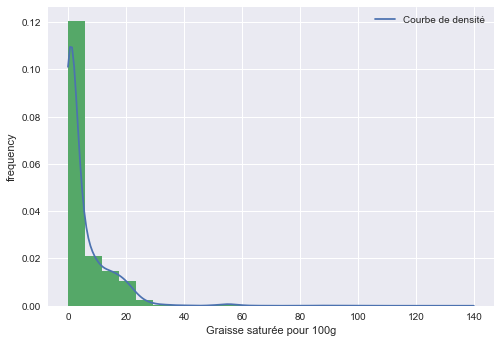

In [86]:
plot_histo(data_filtre['saturated-fat_100g'], bins=24, xlabel="Graisse saturée pour 100g")

<a id='univ_7'></a>
### Nutriscore 🔢 (numérique)

In [87]:
data_filtre.nutriscore_score.describe()

count    92134.000000
mean         8.109189
std          9.067266
min        -15.000000
25%          1.000000
50%          7.000000
75%         15.000000
max         36.000000
Name: nutriscore_score, dtype: float64

C'est une variable quantitative sur la qualité des aliments

Voici la documentation:

<img src="img/nutriscore.png" style="height:250px">

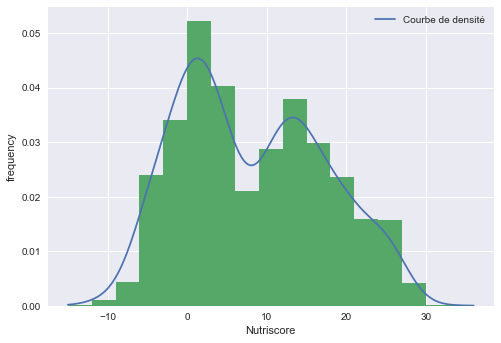

In [88]:
plot_histo(data_filtre['nutriscore_score'], xlabel="Nutriscore")

Mesure de la symetrie avec Skewness : 

In [89]:
data_filtre.nutriscore_score.skew()

0.2666510717738149

On voit que la distribution est quasi symétrique avec un léger décalage à gauche

<a id='univ_8'></a>
### Nutriscore 🔠 (grade)

In [90]:
data_filtre.nutriscore_grade.describe()

count     92134
unique        5
top           d
freq      24602
Name: nutriscore_grade, dtype: object

In [91]:
data_filtre.nutriscore_grade.unique()

array(['b', 'e', 'd', 'c', 'a'], dtype=object)

In [92]:
data_filtre.nutriscore_grade.value_counts()

d    24602
c    20106
a    17394
e    15929
b    14103
Name: nutriscore_grade, dtype: int64

Cette note connue du grand public est une note de A à E (A étant la meilleure et E la moins bonne). C'est donc une variable qualitative ordonnée. On peut la traiter comme une variable quantitative

In [93]:
data_filtre['nutriscore_grade_num'] = data_filtre.nutriscore_grade.replace({'a':4, 'b':3, 'c':2, 'd':1, 'e':0})

In [94]:
data_pie_nutriscore = data_filtre['nutriscore_grade_num'].value_counts().sort_index()

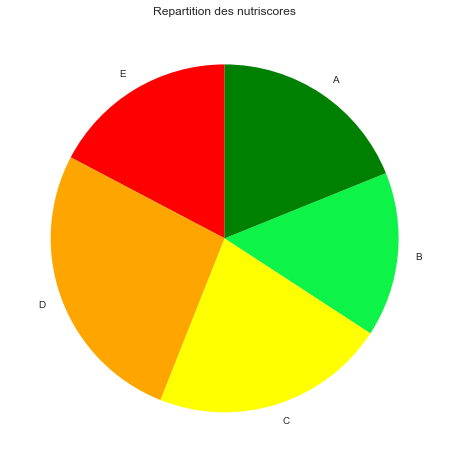

In [95]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.title("Repartition des nutriscores")
plt.pie(data_pie_nutriscore, labels=['E', 'D', 'C', 'B', 'A'], colors=['red','orange','yellow', '#0DF347', 'green'], startangle=90)
plt.show()

No handles with labels found to put in legend.


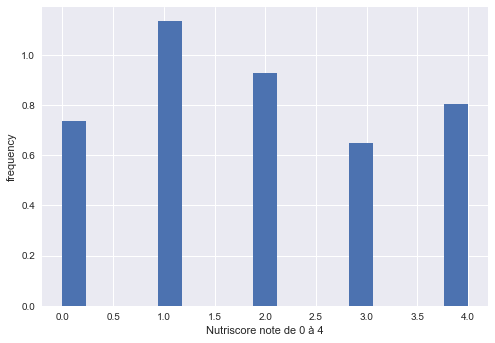

In [96]:
plot_histo(data_filtre['nutriscore_grade_num'], plot_density=False, xlabel='Nutriscore note de 0 à 4')

In [97]:
data_filtre['nutriscore_grade_num'].describe()

count    92134.000000
mean         1.917848
std          1.363849
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: nutriscore_grade_num, dtype: float64

In [98]:
data_filtre['nutriscore_grade_num'].skew()

0.18615294514462896

In [99]:
data_filtre['nutriscore_grade_num'].kurtosis()

-1.1829259288549363

La repartition n'est pas uniforme mais fera quand mêmel'approximation qu'elle l'est au regard de l'écart interquartile, de kurtosis et de skewness

# Analyses Bivariées 📈

## 1: Analyse bivariée entre le type d'emballage et le nutriscore_score

In [100]:
X = "has_plastic" # qualitative
Y = "nutriscore_score" # quantitative

In [101]:
echantillon_1 = data_filtre[['nutriscore_score', 'has_plastic']]

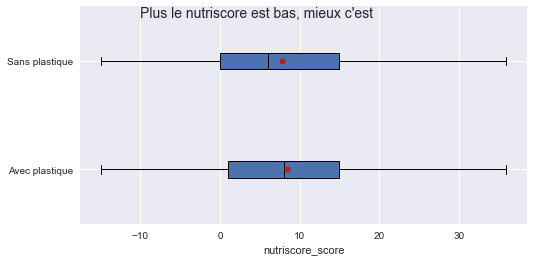

In [102]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_1[echantillon_1[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=['Avec plastique', 'Sans plastique'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.text(-10,2.4, "Plus le nutriscore est bas, mieux c'est", fontsize=14)
plt.xlabel(Y)
plt.show()

On voit que la moyenne et la mediane sont plus faibles (donc meilleures) pour les produits sans plastiques

In [103]:
X = "has_plastic" # qualitative
Y = "nutriscore_grade_num" # quantitative
echantillon_2 = data_filtre[[Y, X]]

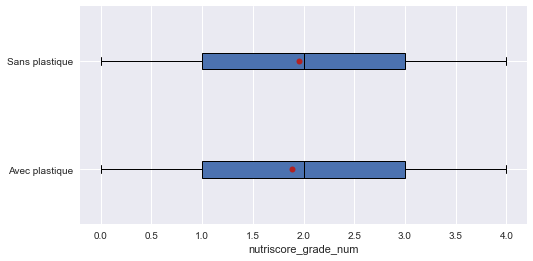

In [104]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_2[echantillon_2[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=['Avec plastique', 'Sans plastique'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.show()

Sur ce graphe on voit que la repartition du nutriscore (grade) est similaire pour les deux classes. On remarque par contre que la moyenne est inférieure pour les produits emballés dans du plastique

## 2: Analyse bivariée entre le type d'emballage et le nutriscore_grade

### Avec seulement deux catégories plastique/pas de plastique

Tableau de contingence

In [105]:
data_filtre.has_plastic.value_counts()

True     49261
False    42873
Name: has_plastic, dtype: int64

In [106]:
X = "nutriscore_grade"
Y = "has_plastic"

echantillon_3 = data_filtre[['nutriscore_grade', 'has_plastic']]
cont = echantillon_3[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len ,margins=True,margins_name="Total")

In [107]:
cont['Freq_False'] = cont.loc[:,0] / cont.Total * 100

In [108]:
cont

has_plastic,False,True,Total,Freq_False
nutriscore_grade,,,,
a,8152,9242,17394,46.866736
b,7230,6873,14103,51.265688
c,9579,10527,20106,47.642495
d,10526,14076,24602,42.785139
e,7386,8543,15929,46.368259
Total,42873,49261,92134,46.533310


# Analyse statistique: 💯
Obtention de l'intervalle de confiance de la proportion de produits sans plastique dans la population Nutriscore Grade = A ou B

In [109]:
echantillon_4 = data_filtre[data_filtre['nutriscore_grade'].isin(['a', 'b'])][['nutriscore_grade', 'has_plastic']].replace({True:0, False:1}).rename(columns={'has_plastic': 'no_plastic'})

In [110]:
echantillon_4.head(5)

,nutriscore_grade,no_plastic
323,b,0
346,b,0
406,b,0
906,a,1
911,a,1


In [111]:
n_produits_sains = len(echantillon_4)
n_produits_sains_sans_platique = echantillon_4.no_plastic.sum()
proportion_estim = n_produits_sains_sans_platique / n_produits_sains

In [112]:
proportion_estim

0.48836397117185765

Niveau de confiance

In [113]:
from statsmodels.stats.proportion import proportion_confint

In [114]:
alpha = 0.05
proportion_confint(n_produits_sains_sans_platique, n_produits_sains, alpha=alpha, method='normal')

(0.4828436307032652, 0.4938843116404501)

On peut ici affirmer que le taux d'aliments sans plastique dans la population d'aliments "sains" (c-à-d des groupes A et B) est supérieur au taux général d'aliment sans plastique sur l'ensemble de la population dont l'intervalle de confiance est rappelé ci dessous.  cf [Analyse univariée de la variable "has_plastic"](#univ_3)

In [115]:
interv_conf_propor_pduits_sans_plastique

(0.4621072858615713, 0.4685488165967779)

# Tests statistiques 🔦

Objectif : Montrer statistiquement que la moyenne des nutriscores (grades) des produits sans plastique est supérieure à celle des produits ayant du plastique.

Pour cela je vais d'abord estimer la moyenne des nutriscores des aliments avec plastique sous forme d'intervalle de confiance et prendre le "pire" cas. C'est à dire la borne supérieure de cet IC
Je menerai ensuite un test statistique sur la moyenne des nutriscore des produits sans plastique.

In [116]:
moy_empirique_plastique = data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].mean()
sigma_empirique_plastique = data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].std()
n_echantillon_plastique = len(data_filtre[data_filtre['has_plastic']])

In [117]:
alpha = 0.05
ic_sup_moy_nutriscore_plast = moy_empirique_plastique + t.ppf(1 - alpha / 2 , n_echantillon_plastique - 1)*sigma_empirique_plastique/sqrt(n_echantillon_plastique)
ic_sup_moy_nutriscore_plast

1.8941877214944876

In [118]:
moy_empirique_plastique

1.8821582996691095

In [119]:
sigma_empirique_plastique

1.3621897370079576

On teste : 
- H0 : μ = ic_sup_moy_nutriscore_plast (les produits plastiques ont la même moyenne de nutriscore que les produits sans plastiques)
- H1 : μ > ic_sup_moy_nutriscore_plast (les produits sans plastique ont un nutriscore moyen supérieur au produits emballés dans du plastique)

In [120]:
test_IC = ttest_1samp(data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'],ic_sup_moy_nutriscore_plast)

In [121]:
test_IC.pvalue

1.0540342836313675e-22

Ce test est "two sided". il faut donc diviser la p-value par 2

In [122]:
p_value_test_ic = test_IC.pvalue / 2

In [123]:
p_value_test_ic

5.2701714181568375e-23

On peut rejeter l'hypothèse H0

On teste : 
- H0 : μ_no_plast <= μ_plast (les produits sans plastiques ont une moyenne de nutriscore inférieure ou égale à celle des produits emballés dans du plastique)
- H1 : μ_no_plast > μ_plast (les produits sans plastiques ont une moyenne de nutriscore supérieure à celle des produits emballés dans du plastique)

In [124]:
data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'].mean()

1.95885522356728

In [125]:
data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'].mean()

1.8821582996691095

In [126]:
test_bi_variable = ttest_ind(data_filtre[data_filtre['has_plastic'] == False]['nutriscore_grade_num'],
                             data_filtre[data_filtre['has_plastic']]['nutriscore_grade_num'])

In [127]:
test_bi_variable.pvalue

1.6539853455089036e-17

Ce test est "two sided". il faut donc diviser la p-value par 2

In [128]:
p_value_test_bi_variable = test_bi_variable.pvalue / 2

In [129]:
p_value_test_bi_variable

8.269926727544518e-18

On peut egalement rejeter l'hypothèse H0

Regardons si on peut affirmer cette hypothèse pour toutes les catégories

In [130]:
p_values_categs = {}
size_categs = {}
for categ in data_filtre.pnns_groups_2.unique():
    data_categ = data_filtre[data_filtre['pnns_groups_2'] == categ]
    size_categs[categ] = len(data_categ)
    p_values_categs[categ] = ttest_ind(data_categ[data_categ['has_plastic'] == False]['nutriscore_grade_num'],
                                       data_categ[data_categ['has_plastic']]['nutriscore_grade_num']).pvalue/2

In [131]:
p_values_categs = pd.Series(p_values_categs)
size_categs = pd.Series(size_categs)

In [132]:
df_p_values_categs = pd.DataFrame({'p_values' : p_values_categs.values, 'size_echantillon' : size_categs.values}, index=p_values_categs.index)

In [133]:
df_p_values_categs.sort_values(by=['p_values'], ascending=False, inplace=True)

Catégories pour lesquelles on ne peux pas rejetter H0:

In [134]:
df_p_values_categs[df_p_values_categs['p_values'] > 0.05]

,p_values,size_echantillon
unknown,0.497316,7580
fruits,0.483708,1711
legumes,0.473002,1125
eggs,0.435132,348
salty and fatty products,0.427126,2252
artificially sweetened beverages,0.404987,764
plant-based milk substitutes,0.357124,1137
pastries,0.342487,760
offals,0.321990,213
milk and yogurt,0.315769,4832


Regardes la variance , moyenne, std pour les fruits oeufs et legumes

In [135]:
df_p_values_categs[df_p_values_categs['p_values'] < 0.05]

,p_values,size_echantillon
potatoes,4.807203e-02,563
bread,4.631382e-02,2485
teas and herbal teas and coffees,3.767279e-02,83
ice cream,3.063641e-02,1411
soups,2.326029e-02,798
waters and flavored waters,7.378177e-03,216
dairy desserts,7.009000e-03,1549
sweetened beverages,6.115691e-03,2040
chocolate products,3.849911e-03,3001
fruit juices,2.231548e-03,1859


On voit que pour certaines catégories on a très peu de données. Pour celles ci il semble assez logique qu'on ne puisse rien déduire. On remarque aussi que la catégorie "unknown" est la pire en terme de p_value bien qu'ayant un gros echantillon. Cela confirme la necessité de completer cette donnée

# idem avec groups_1

In [165]:
p_values_categs = {}
size_categs = {}
for categ in data_filtre.pnns_groups_1.unique():
    data_categ = data_filtre[data_filtre['pnns_groups_1'] == categ]
    size_categs[categ] = len(data_categ)
    p_values_categs[categ] = ttest_ind(data_categ[data_categ['has_plastic'] == False]['nutriscore_grade_num'],
                                       data_categ[data_categ['has_plastic']]['nutriscore_grade_num']).pvalue/2

In [166]:
p_values_categs = pd.Series(p_values_categs)
size_categs = pd.Series(size_categs)

In [167]:
df_p_values_categs = pd.DataFrame({'p_values' : p_values_categs.values, 'size_echantillon' : size_categs.values}, index=p_values_categs.index)

In [168]:
df_p_values_categs.sort_values(by=['p_values'], ascending=False, inplace=True)

Catégories pour lesquelles on ne peux pas rejetter H0:

In [173]:
df_p_values_categs[df_p_values_categs['p_values'] > 0.02]

,p_values,size_echantillon
unknown,0.497316,7580


Regardes la variance , moyenne, std pour les fruits oeufs et legumes

In [174]:
df_p_values_categs[df_p_values_categs['p_values'] < 0.02]

,p_values,size_echantillon
Fruits and vegetables,1.295174e-02,6632
Milk and dairy products,1.210739e-03,12473
Composite foods,9.421522e-04,9382
Cereals and potatoes,1.744979e-04,11405
Sugary snacks,5.472196e-05,17168
Salty snacks,2.125868e-07,5050
Beverages,1.819485e-07,6668
Fat and sauces,5.329758e-53,5167
Fish Meat Eggs,1.272685e-72,10609


Idem avec les données completées

Conclusion

Perspectives